In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM  # importing layers package , Dense layer is used to connect all layers
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [3]:
dataset5 = web.DataReader('MARICO.NS', data_source='yahoo',start='2015-08-30',end='2022-10-6')
dataset5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-31,209.949997,201.100006,203.250000,202.774994,1408430.0,180.887695
2015-09-01,205.274994,200.050003,201.899994,202.425003,922644.0,180.575470
2015-09-02,206.000000,200.699997,206.000000,202.475006,1640322.0,180.620071
2015-09-03,203.625000,201.250000,202.250000,202.750000,903636.0,180.865356
2015-09-04,203.425003,199.149994,203.425003,200.875000,436216.0,179.192749
...,...,...,...,...,...,...
2022-09-29,552.450012,532.000000,550.099976,538.400024,2384651.0,538.400024
2022-09-30,541.650024,529.099976,538.400024,537.849976,1942784.0,537.849976
2022-10-03,541.799988,523.049988,540.000000,529.500000,1776834.0,529.500000


In [4]:
len(dataset5)

1752

In [5]:
dataset5.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-29,552.450012,532.000000,550.099976,538.400024,2384651.0,538.400024
2022-09-30,541.650024,529.099976,538.400024,537.849976,1942784.0,537.849976
2022-10-03,541.799988,523.049988,540.000000,529.500000,1776834.0,529.500000
2022-10-04,537.000000,520.000000,537.000000,526.099976,3048584.0,526.099976
2022-10-06,531.450012,522.500000,531.450012,525.099976,1155972.0,525.099976


In [6]:
opn=dataset5[['Open']]

<AxesSubplot:xlabel='Date'>

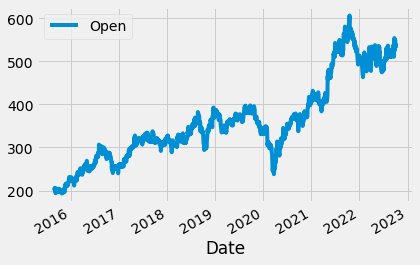

In [7]:
opn.plot()

In [8]:
ds=opn.values

In [9]:
ds

array([[203.25      ],
       [201.8999939 ],
       [206.        ],
       ...,
       [540.        ],
       [537.        ],
       [531.45001221]])

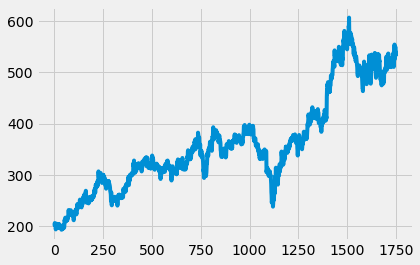

In [10]:
plt.plot(ds)

In [11]:
normalizer=MinMaxScaler(feature_range=(0,1))
ds_scaled=normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [12]:
len(ds_scaled),len(ds)

(1752, 1752)

In [13]:
train_size=int(len(ds_scaled)*0.70)
test_size=len(ds_scaled)-train_size

In [14]:
train_size,test_size

(1226, 526)

In [15]:
ds_train,ds_test=ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [16]:
len(ds_train),len(ds_test)

(1226, 526)

In [17]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [18]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [19]:
X_train.shape,y_train.shape

((1125, 100), (1125,))

In [20]:
X_test.shape, y_test.shape

((425, 100), (425,))

In [21]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=90,batch_size=90)

Epoch 1/90
13/13 [==============================] - 12s 376ms/step - loss: 0.0315 - val_loss: 0.0687
Epoch 2/90
13/13 [==============================] - 3s 208ms/step - loss: 0.0048 - val_loss: 0.0172
Epoch 3/90
13/13 [==============================] - 3s 220ms/step - loss: 0.0027 - val_loss: 0.0411
Epoch 4/90
13/13 [==============================] - 3s 205ms/step - loss: 0.0017 - val_loss: 0.0177
Epoch 5/90
13/13 [==============================] - 3s 217ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 6/90
13/13 [==============================] - 3s 222ms/step - loss: 9.1102e-04 - val_loss: 0.0023
Epoch 7/90
13/13 [==============================] - 3s 199ms/step - loss: 8.9630e-04 - val_loss: 0.0019
Epoch 8/90
13/13 [==============================] - 3s 209ms/step - loss: 9.0255e-04 - val_loss: 0.0024
Epoch 9/90
13/13 [==============================] - 3s 212ms/step - loss: 8.5892e-04 - val_loss: 0.0031
Epoch 10/90
13/13 [==============================] - 3s 199ms/step - loss: 8.4552e-

13/13 [==============================] - 3s 196ms/step - loss: 3.5285e-04 - val_loss: 9.7666e-04
Epoch 80/90
13/13 [==============================] - 3s 201ms/step - loss: 3.5025e-04 - val_loss: 0.0010
Epoch 81/90
13/13 [==============================] - 3s 215ms/step - loss: 3.4603e-04 - val_loss: 9.7620e-04
Epoch 82/90
13/13 [==============================] - 3s 212ms/step - loss: 3.6492e-04 - val_loss: 0.0018
Epoch 83/90
13/13 [==============================] - 3s 210ms/step - loss: 3.2618e-04 - val_loss: 9.5581e-04
Epoch 84/90
13/13 [==============================] - 3s 210ms/step - loss: 3.3918e-04 - val_loss: 9.5816e-04
Epoch 85/90
13/13 [==============================] - 3s 205ms/step - loss: 3.7672e-04 - val_loss: 0.0033
Epoch 86/90
13/13 [==============================] - 3s 201ms/step - loss: 3.5166e-04 - val_loss: 0.0014
Epoch 87/90
13/13 [==============================] - 3s 219ms/step - loss: 3.1922e-04 - val_loss: 0.0010
Epoch 88/90
13/13 [==============================] 

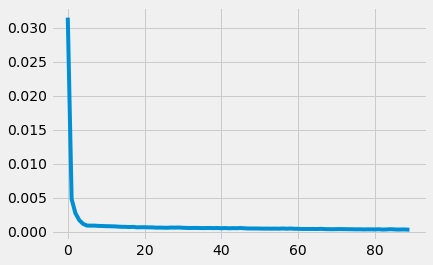

In [24]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [25]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [26]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

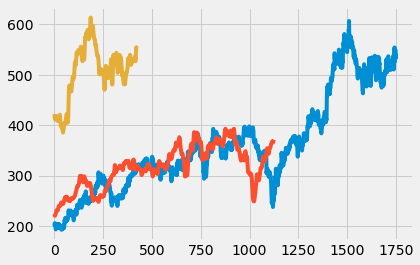

In [27]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled),label= 'Scaled Value')
plt.plot((train_predict),label= 'Training value')
plt.plot((test_predict),label= 'Testing value')

In [28]:
type(train_predict)

numpy.ndarray

In [29]:
test = np.vstack((train_predict,test_predict))

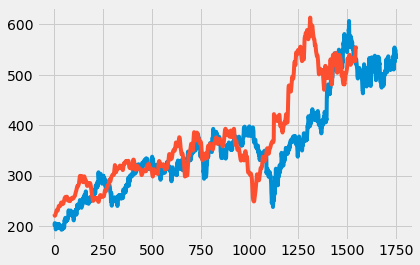

In [30]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [31]:
len(ds_test)

526

In [32]:
#Getting the last 100 days records
fut_inp = ds_test[426:]

In [33]:
fut_inp = fut_inp.reshape(1,-1)

In [34]:
tmp_inp = list(fut_inp)

In [35]:
fut_inp.shape

(1, 100)

In [36]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [37]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8560014963150024], [0.8599876165390015], [0.8713973164558411], [0.8871446251869202], [0.9052480459213257], [0.9247036576271057], [0.945040762424469], [0.9660481810569763], [0.9876745343208313], [1.0100154876708984], [1.0333120822906494], [1.0579396486282349], [1.0843784809112549], [1.1131764650344849], [1.1449092626571655], [1.1801471710205078], [1.2194246053695679], [1.263224482536316], [1.311965823173523], [1.3660017251968384], [1.4256160259246826], [1.4910221099853516], [1.5623538494110107], [1.6396467685699463], [1.7228091955184937], [1.811576247215271], [1.9054653644561768], [2.003730535507202], [2.105344772338867], [2.209016799926758]]


In [38]:
len(ds_scaled)

1752

In [39]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

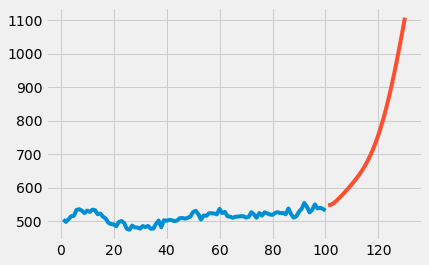

In [40]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1652:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [41]:
ds_new = ds_scaled.tolist()

In [42]:
len(ds_new)

1752

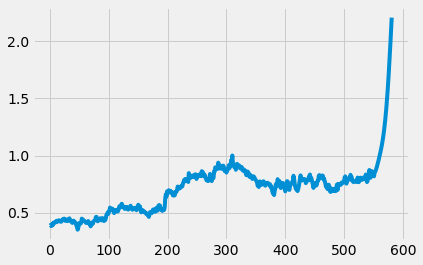

In [43]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [44]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

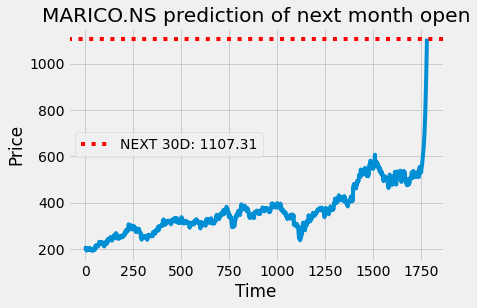

In [45]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format('MARICO.NS'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [93]:
final_graph

[[203.25],
 [201.89999389648438],
 [206.0],
 [202.25],
 [203.4250030517578],
 [201.5500030517578],
 [198.75],
 [193.5749969482422],
 [196.875],
 [198.5],
 [203.0],
 [204.6999969482422],
 [203.72500610351562],
 [203.72500610351562],
 [201.22500610351562],
 [202.5500030517578],
 [196.5],
 [199.0],
 [199.75],
 [197.1999969482422],
 [199.9499969482422],
 [204.0],
 [200.14999389648438],
 [201.75],
 [204.0],
 [201.0],
 [201.0500030517578],
 [200.3249969482422],
 [197.5],
 [196.47500610351562],
 [197.97500610351562],
 [200.9499969482422],
 [200.0],
 [200.0749969482422],
 [197.0],
 [197.0],
 [193.0],
 [194.6999969482422],
 [196.5],
 [196.5],
 [196.25],
 [193.9499969482422],
 [194.0],
 [195.47500610351562],
 [201.3000030517578],
 [202.47500610351562],
 [199.97500610351562],
 [202.4499969482422],
 [201.5],
 [198.0500030517578],
 [196.75],
 [201.75],
 [212.0],
 [210.0],
 [210.50000000000003],
 [215.75],
 [216.5],
 [216.47500610351562],
 [209.0],
 [212.67500305175778],
 [213.02499389648438],
 [214

In [95]:
for i in range(0,len(final_graph)):
    print(final_graph[i])


[203.25]
[201.89999389648438]
[206.0]
[202.25]
[203.4250030517578]
[201.5500030517578]
[198.75]
[193.5749969482422]
[196.875]
[198.5]
[203.0]
[204.6999969482422]
[203.72500610351562]
[203.72500610351562]
[201.22500610351562]
[202.5500030517578]
[196.5]
[199.0]
[199.75]
[197.1999969482422]
[199.9499969482422]
[204.0]
[200.14999389648438]
[201.75]
[204.0]
[201.0]
[201.0500030517578]
[200.3249969482422]
[197.5]
[196.47500610351562]
[197.97500610351562]
[200.9499969482422]
[200.0]
[200.0749969482422]
[197.0]
[197.0]
[193.0]
[194.6999969482422]
[196.5]
[196.5]
[196.25]
[193.9499969482422]
[194.0]
[195.47500610351562]
[201.3000030517578]
[202.47500610351562]
[199.97500610351562]
[202.4499969482422]
[201.5]
[198.0500030517578]
[196.75]
[201.75]
[212.0]
[210.0]
[210.50000000000003]
[215.75]
[216.5]
[216.47500610351562]
[209.0]
[212.67500305175778]
[213.02499389648438]
[214.55000305175778]
[210.625]
[212.10000610351562]
[211.3000030517578]
[213.9250030517578]
[214.69999694824222]
[212.399993896

In [96]:
writer=pd.ExcelWriter('Marico_Sept.xlsx')

In [97]:
data1=pd.DataFrame({'Predictions':final_graph})

In [98]:
data1.to_excel(writer)

In [99]:
writer.save()